##Remove Folders

In [30]:
#import shutil
#shutil.rmtree('/content/drive/MyDrive/PestsImages')

##Unzip Dataset

In [31]:
!unzip -q /content/drive/MyDrive/PestsImages

##Import Moduls

In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from keras.preprocessing.image import load_img
from tensorflow.keras import models,layers
warnings.filterwarnings('ignore')

###(1 = rice_gall_midge, 0 = brown_plant_hopper)

##Create Dataframe for Input and Output

In [33]:
input_path = []
label = []

for class_name in os.listdir("PestsImages"):
  for path in os.listdir("PestsImages/"+class_name):
    if class_name == 'rice_gall_midge':
      label.append(1)
    if class_name == 'brown_plant_hopper':
      label.append(0)
    input_path.append(os.path.join("PestsImages", class_name, path))


#####print(input_path[0], label[0])
#####len(label)
#####len(input_path)

In [34]:
len(input_path)

1582

In [35]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PestsImages/brown_plant_hopper/7 (662).jpg,0
1,PestsImages/rice_gall_midge/5 (266).jpg,1
2,PestsImages/brown_plant_hopper/7 (63).jpg,0
3,PestsImages/brown_plant_hopper/7 (688).jpg,0
4,PestsImages/brown_plant_hopper/7 (549).jpg,0


In [36]:
df['label'] = df['label'].astype('str')

Exploratory Data Analysis

In [37]:
#to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('rice_gall_midge')
  plt.axis('off')


<Figure size 2500x2500 with 0 Axes>

In [38]:
#to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('brown_plant_hopper')
  plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

<Axes: ylabel='count'>

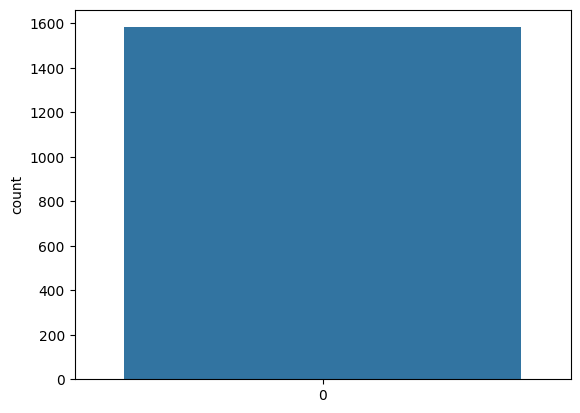

In [39]:
import seaborn as sns
sns.countplot(df['label'])

##Create DataGenerator for the Images

In [40]:
df.head()

,images,label
0,PestsImages/brown_plant_hopper/7 (662).jpg,0
1,PestsImages/rice_gall_midge/5 (266).jpg,1
2,PestsImages/brown_plant_hopper/7 (63).jpg,0
3,PestsImages/brown_plant_hopper/7 (688).jpg,0
4,PestsImages/brown_plant_hopper/7 (549).jpg,0


In [41]:
#input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [44]:
train.tail()

,images,label
1130,PestsImages/brown_plant_hopper/7 (344).jpg,0
1294,PestsImages/rice_gall_midge/5 (81).jpg,1
860,PestsImages/brown_plant_hopper/7 (223).jpg,0
1459,PestsImages/brown_plant_hopper/7 (155).jpg,0
1126,PestsImages/brown_plant_hopper/7 (0).jpg,0


In [45]:
train.shape, test.shape

((1265, 2), (317, 2))

In [46]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, #normalization of images
    rotation_range = 40, #augmentation of images to avoid overfitting
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 1265 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


###Data Augmentation

In [47]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

##Model Creation

In [70]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    #data_augmentation,
    Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [71]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 64)       

In [72]:
history = model.fit(train_iterator, epochs=50, validation_data=val_iterator)

Epoch 1/50
3/3 [==============================] - 12s 4s/step - loss: 1.3277 - accuracy: 0.4751 - val_loss: 1.0235 - val_accuracy: 0.4953
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 0.8532 - accuracy: 0.5012 - val_loss: 0.7006 - val_accuracy: 0.4953
Epoch 3/50
3/3 [==============================] - 12s 5s/step - loss: 0.6972 - accuracy: 0.4743 - val_loss: 0.6922 - val_accuracy: 0.5047
Epoch 4/50
3/3 [==============================] - 7s 3s/step - loss: 0.6925 - accuracy: 0.5043 - val_loss: 0.6875 - val_accuracy: 0.5110
Epoch 5/50
3/3 [==============================] - 9s 4s/step - loss: 0.6883 - accuracy: 0.5518 - val_loss: 0.6858 - val_accuracy: 0.5741
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.6821 - accuracy: 0.5597 - val_loss: 0.6780 - val_accuracy: 0.5584
Epoch 7/50
3/3 [==============================] - 9s 3s/step - loss: 0.6723 - accuracy: 0.5834 - val_loss: 0.6649 - val_accuracy: 0.5868
Epoch 8/50
3/3 [=======================

##Visualization of Results

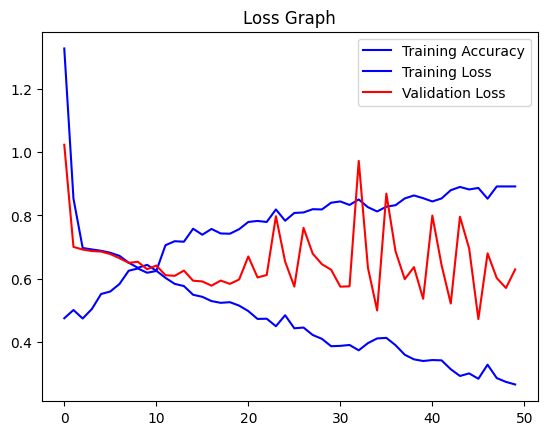

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

###Save Model

In [62]:
import pickle

with open('../content/drive/MyDrive/testModel.pickle', 'wb') as file:
  pickle.dump(model, file)

###Testing Model

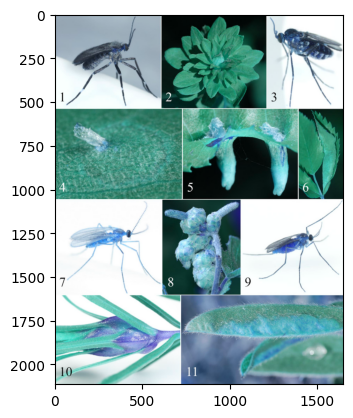

In [63]:
import cv2
img = cv2.imread('../content/drive/MyDrive/rice_gall_midge2.jpg')
plt.imshow(img)
plt.show()


###Image Resize

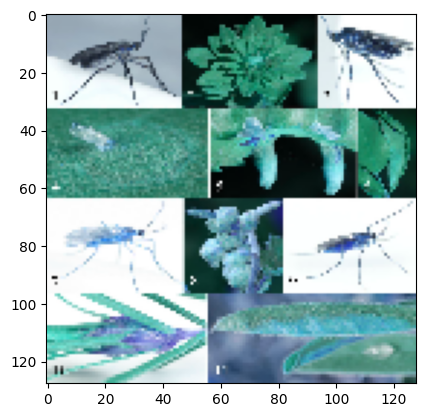

In [64]:
resize = tf.image.resize(img,(128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize, 0)

array([[[[  8.      ,  25.      ,  28.      ],
         [  8.      ,  25.      ,  28.      ],
         [  7.078125,  24.078125,  27.078125],
         ...,
         [ 39.09375 , 150.78125 , 162.78125 ],
         [ 40.203125, 142.29688 , 155.29688 ],
         [ 32.03125 , 114.57568 , 125.40625 ]],

        [[  8.      ,  25.      ,  28.      ],
         [  8.      ,  25.      ,  28.      ],
         [  7.921875,  24.921875,  27.921875],
         ...,
         [ 35.114746, 147.11475 , 159.11475 ],
         [ 41.071777, 137.10303 , 151.60938 ],
         [ 30.992676, 107.03125 , 119.046875]],

        [[  7.      ,  24.      ,  27.      ],
         [  7.046875,  24.046875,  27.046875],
         [  7.      ,  24.      ,  27.      ],
         ...,
         [ 40.57666 , 147.92041 , 160.13916 ],
         [ 39.734375, 130.92188 , 145.92188 ],
         [ 31.59375 , 103.625   , 113.65625 ]],

        ...,

        [[ 16.      ,  67.78125 ,  75.4375  ],
         [ 15.046875,  67.046875,  73.265625]

In [ ]:
np.expand_dims(resize, 0).shape

(1, 128, 128, 3)

In [65]:
yhat2 = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 68ms/step


In [66]:
yhat2

if yhat2>0.5:
  print("This is Rice Gall Midge")
else:
  print("This is Brown Plant Hopper")

This is Rice Gall Midge


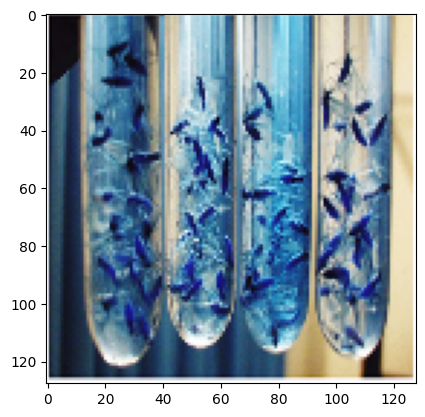

In [67]:
img = cv2.imread('/content/drive/MyDrive/rice_gall_midge3.jpg')
plt.imshow(img)
resize = tf.image.resize(img,(128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [68]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [ ]:
yhat

array([[0.9861709]], dtype=float32)

In [69]:
if yhat>0.5:
  print("This is Rice Gall Midge")
else:
  print("This is Brown Plant Hopper")

This is Rice Gall Midge


In [3]:
import pickle
with open('/content/drive/MyDrive/testModel.pickle', 'rb') as f:
    model = pickle.load(f)

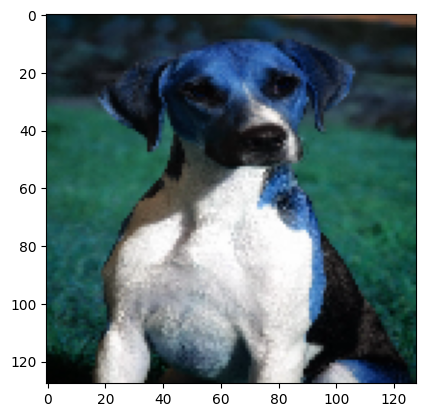

In [19]:
#print(resize/255)
import cv2
img = cv2.imread('/content/drive/MyDrive/dog2.jpg')
plt.imshow(img)
resize = tf.image.resize(img,(128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [20]:
y = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [21]:
print(y)

[[0.34595212]]


In [18]:
if y>0.5:
  print("This is Rice Gall Midge")
elif 0.5>=y>=0:
  print("This is Brown Plant Hopper")
else:
  print("Something else")

This is Rice Gall Midge
